<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Lecture-overview" data-toc-modified-id="Lecture-overview-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Lecture overview</a></span></li><li><span><a href="#Preliminaries" data-toc-modified-id="Preliminaries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preliminaries</a></span></li><li><span><a href="#Subperiod-analysis" data-toc-modified-id="Subperiod-analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Subperiod analysis</a></span></li><li><span><a href="#Conditioning-on-cross-sectional-information" data-toc-modified-id="Conditioning-on-cross-sectional-information-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Conditioning on cross-sectional information</a></span></li><li><span><a href="#Conditioning-on-both-time-and-the-cross-section" data-toc-modified-id="Conditioning-on-both-time-and-the-cross-section-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Conditioning on both time and the cross-section</a></span></li><li><span><a href="#Advanced-&quot;binning&quot;-example" data-toc-modified-id="Advanced-&quot;binning&quot;-example-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Advanced "binning" example</a></span><ul class="toc-item"><li><span><a href="#Multi-dimensional-bins" data-toc-modified-id="Multi-dimensional-bins-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Multi-dimensional bins</a></span></li></ul></li></ul></div>

# Lecture overview

Loosely speaking, "conditional descriptive statistics" are statistics calculated for subsamples (subsets) of your data. The information you use to create these subsamples is referred to as the "conditioning information". In this lecture, we showcase these types of descriptive statistics using the tools learned in the previous lecture, and a panel dataset: the "compa" file, which contains accounting information for multiple firms over multiple years. 

In the previous lecture we calculated conditional statistics in situations where the variable which dictated what observations are in what subsample already exists in the dataset. For example, we calculated average returns for each industry separately. In that example, the returns of each individual industry constitute a separate subsample of our data. The "conditioning information" which allowed us to specify which observation was in what sample was the "Industry" variable (which already existed in the dataset).

In this lecture, we will focus on examples where we have to create ourselves the variable which specifies which observation is in what sample. 

# Preliminaries

In [1]:
import pandas as pd
import numpy as np

Get raw data:

In [2]:
comp_raw = pd.read_pickle('../data/compa.zip')
comp_raw.dtypes

permno      float64
datadate     object
gvkey        object
tic          object
conm         object
at          float64
capx        float64
che         float64
cogs        float64
csho        float64
dlc         float64
dltt        float64
dp          float64
dvc         float64
ib          float64
oancf       float64
ppegt       float64
ppent       float64
revt        float64
sale        float64
fic          object
prcc_f      float64
sich        float64
dtype: object

Clean it up a bit:

In [3]:
# Sort by firm identifier and date
comp_raw.sort_values(['permno','datadate'], inplace = True)
# Extract year from the date
comp_raw['year'] = pd.to_datetime(comp_raw['datadate']).dt.year
comp_raw.head(2)

,permno,datadate,gvkey,tic,conm,at,capx,che,cogs,csho,...,ib,oancf,ppegt,ppent,revt,sale,fic,prcc_f,sich,year
188730,10000.0,1986-10-31,013007,OMFGA,OPTIMUM MANUFACTURING -CL A,2.115,0.240,0.348,0.511,3.843,...,-0.730,NaN,0.328,0.189,1.026,1.026,USA,0.75,NaN,1986
188550,10001.0,1986-06-30,012994,EGAS,GAS NATURAL INC,12.242,0.551,0.746,19.565,0.985,...,0.669,NaN,13.021,8.216,21.460,21.460,USA,6.00,NaN,1986


Create a new dataframe with firm and year identifiers for firms with positive total assets:

In [4]:
comp = comp_raw.loc[comp_raw['at']>0, ['permno','year', 'sich']].copy()

And calculate some key variables:

In [5]:
comp['inv'] = comp_raw['capx'] / comp_raw['at']
comp['roa'] = comp_raw['ib'] / comp_raw['at']
comp['lev'] = (comp_raw['dlc'] + comp_raw['dltt']) / comp_raw['at']
comp['cash'] = comp_raw['che'] / comp_raw['at']

In [6]:
comp.describe()

,permno,year,sich,inv,roa,lev,cash
count,237017.000000,237017.000000,192174.000000,221486.000000,236472.000000,235458.000000,236417.000000
mean,59908.145365,1999.543877,4734.864368,0.060206,-0.056431,0.243002,0.174782
std,28075.843586,11.096752,1986.202863,0.111862,1.494764,0.313886,0.219955
min,10000.000000,1980.000000,100.000000,-2.093398,-218.000000,-0.050045,-0.069190
25%,33420.000000,1991.000000,3320.000000,0.011996,-0.032695,0.042258,0.025310
50%,75049.000000,1999.000000,4581.000000,0.035232,0.018931,0.191382,0.080652
75%,83492.000000,2008.000000,6321.000000,0.075212,0.061761,0.369135,0.234988
max,93436.000000,2020.000000,9998.000000,31.000000,226.310379,39.592899,1.000000


**Challenge**

Winsorize the 'inv','roa','lev','cash' variables at the 1 and 99th percentiles and get full-sample summary statistics for them.

In [7]:
for var in ['inv','roa','lev','cash']:
    comp[f'w_{var}'] = comp[var].clip(lower = comp[var].quantile(0.01),
                                    upper = comp[var].quantile(0.99))


In [8]:
comp.filter(like='w_').describe()

,w_inv,w_roa,w_lev,w_cash
count,221486.000000,236472.000000,235458.000000,236417.000000
mean,0.058342,-0.046949,0.236951,0.174446
std,0.072156,0.257251,0.221142,0.218750
min,0.000000,-1.492801,0.000000,0.000181
25%,0.011996,-0.032695,0.042258,0.025310
50%,0.035232,0.018931,0.191382,0.080652
75%,0.075212,0.061761,0.369135,0.234988
max,0.403505,0.265273,0.956589,0.930186


Compare the standard deviations of the winsorized variables above, to the standard deviation of the un-wisnorized variables: 

In [9]:
comp[['inv','roa','lev','cash']].describe()

,inv,roa,lev,cash
count,221486.000000,236472.000000,235458.000000,236417.000000
mean,0.060206,-0.056431,0.243002,0.174782
std,0.111862,1.494764,0.313886,0.219955
min,-2.093398,-218.000000,-0.050045,-0.069190
25%,0.011996,-0.032695,0.042258,0.025310
50%,0.035232,0.018931,0.191382,0.080652
75%,0.075212,0.061761,0.369135,0.234988
max,31.000000,226.310379,39.592899,1.000000


Save the names of the main variables we want to analyze into a list, so we don't have to type them up every time we use them:

In [10]:
main_vars = [ 'w_inv','w_roa','w_lev','w_cash']

# Subperiod analysis

It is often a good idea to test how the results of your analysis change depending on the time period included in the data. This type of testing is generally referred to as "subperiod analysis". We'll cover two such examples below.

In the following example, we calculate means of our key variables **each year** and plot these means to see how they have changed over time.

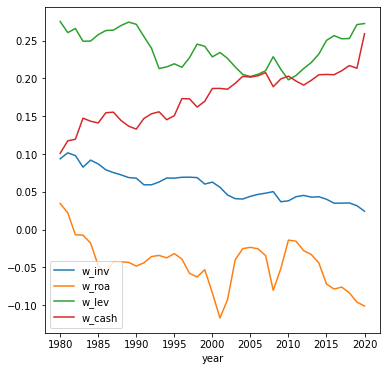

In [11]:
annual_means = comp.groupby('year')[main_vars].mean()
annual_means.plot(figsize = (6,6));

As another example, we now calculate our means separately for the period prior to the year 2000, and the period after. 

To do this, we need to create a new variable in our dataframe that takes one value prior to 2000 and a different value after 2000. *What* these values are, does not matter at all, they just have to be two different values in the pre-2000 and post-2000 eras. An easy way to do this is with the ``where`` function in the ``numpy`` package. This function works exactly like ``if`` in Excel:

Syntax:
```python
numpy.where(condition, x, y)
```
When the condition is true, this returns the value x, and when it is false, it returns the value y.

In [12]:
# The long way:
#comp['pre_post_2000'] = 'pre_2000'
#comp.loc[comp['year'] >= 2000, 'pre_post_2000'] = 'post_2000'

#With "np.where"
comp['pre_post_2000'] = np.where(comp['year']<2000, 'pre_2000', 'post_2000')
comp[['year','pre_post_2000']]

,year,pre_post_2000
188730,1986,pre_2000
188550,1986,pre_2000
188566,1987,pre_2000
188567,1988,pre_2000
188568,1989,pre_2000
...,...,...
493016,2016,post_2000
493017,2017,post_2000
493020,2018,post_2000
493021,2019,post_2000


We can now use the "pre_post_2000" variable with ``.groupby()`` to calculate means separately in the two subperiods:

In [13]:
comp.groupby('pre_post_2000')[main_vars].mean()

,w_inv,w_roa,w_lev,w_cash
pre_post_2000,,,,
post_2000,0.042663,-0.059010,0.227570,0.201954
pre_2000,0.073641,-0.035868,0.245604,0.149072


# Conditioning on cross-sectional information

Our panel dataset has information for many different firms, each year. We refer to the totality of the firms in our sample as the "cross-sectional" dimension of the data (as opposed to the "time" dimension).

In the examples below, we calculate means of our key variables for each sector in the economy. For each sector, we use all the data available for that sector (i.e. all years for all firms in that sector). This means we will have a single mean per sector.

In our example, separate "sectors" are identified by the first digit of the SIC (industry) code of the firm (the "sich" variable in the "comp" dataframe). So this is another example in which we have to create a new variable that specifies which observation is in which subsample (sector).

We do this by first turning "sich" into a string variable (with ``.astype('string')``) and then selecting the first character in that string (with ``.str[0]``):

In [14]:
comp['sic1d'] = comp['sich'].astype('string').str[0]
comp[['sich', 'sic1d']]

,sich,sic1d
188730,NaN,<NA>
188550,NaN,<NA>
188566,4924.0,4
188567,4924.0,4
188568,4924.0,4
...,...,...
493016,3711.0,3
493017,3711.0,3
493020,3711.0,3
493021,3711.0,3


Let's see how many observations we have for each sector:

In [15]:
comp['sic1d'].value_counts()

3    48362
6    33072
2    30133
7    23511
5    17683
4    17545
1    13161
8     7773
9      934
Name: sic1d, dtype: Int64

If you look up the SIC codes:

https://siccode.com/sic-code-lookup-directory

you'll see that, roughly speaking, 3 stands for manufacturing firms (though 2 does as well), and 6 stands for financial firms. So the two largest sectors represented in our sample are manufacturing and finance.

Finally, we calculate sector-level means for each of the main variables, using "sic1d" with the ``groupby`` function. Note how much these statistics differ across sectors:

In [16]:
ind_means = comp.groupby('sic1d')[main_vars].mean()
ind_means

,w_inv,w_roa,w_lev,w_cash
sic1d,,,,
1,0.124419,-0.055356,0.262832,0.116602
2,0.046556,-0.146647,0.229641,0.290008
3,0.047486,-0.055418,0.197940,0.203723
4,0.083914,-0.010957,0.371167,0.091903
5,0.065671,-0.003676,0.259566,0.105802
6,0.010060,0.010051,0.242219,0.117255
7,0.053932,-0.093129,0.195012,0.272164
8,0.052520,-0.065384,0.234222,0.210135
9,0.013155,-0.061711,0.094416,0.237050


# Conditioning on both time and the cross-section

Finally, we showcase an example where we examine how summary statistics vary across groups of firms **and** over time. 

In the example below, we calculate means of our key variables for each sector in the economy, for each year separately. For each sector, we take an average over all the firms in that sector, separately for each year that the sector exists in our dataset. This means we will have a time-series of means for each sector.

In [17]:
ind_anmeans = comp.groupby(['year','sic1d'])[main_vars].mean()
ind_anmeans

w_inv     w_roa     w_lev    w_cash
year sic1d                                        
1982 1      0.000000 -0.021536  0.222899  0.027818
     6      0.020324  0.022094  0.226803  0.107758
1983 1      0.002262  0.018584  0.145025  0.118914
     6      0.015431  0.022255  0.210558  0.107978
1984 1      0.003433  0.028340  0.170928  0.071714
...              ...       ...       ...       ...
2020 5      0.031845 -0.017026  0.412766  0.143202
     6      0.004374  0.003683  0.249704  0.127982
     7      0.023146 -0.086067  0.296964  0.302099
     8      0.020325 -0.053079  0.295074  0.240811
     9      0.001519 -0.055441  0.032119  0.013138

[324 rows x 4 columns]

We now plot some of these sector-specific means to see how they have changed over time. To create these plots, we use the **unstack** function to unstack the industries so their data show up side by side (instead of on top of each other).

In [18]:
ind_means_unstacked = ind_anmeans.unstack('sic1d')
ind_means_unstacked.head()

w_inv                                                                \
sic1d         1         2         3         4   5         6         7   8   9   
year                                                                            
1982   0.000000       NaN       NaN       NaN NaN  0.020324       NaN NaN NaN   
1983   0.002262       NaN       NaN       NaN NaN  0.015431       NaN NaN NaN   
1984   0.003433  0.112669  0.050054       NaN NaN  0.013060  0.107678 NaN NaN   
1985        NaN  0.086889  0.043671       NaN NaN  0.015411  0.140073 NaN NaN   
1986        NaN  0.025808  0.035173  0.022611 NaN  0.010504  0.115635 NaN NaN   

          w_roa  ... w_lev    w_cash                                    \
sic1d         1  ...     9         1         2         3         4   5   
year             ...                                                     
1982  -0.021536  ...   NaN  0.027818       NaN       NaN       NaN NaN   
1983   0.018584  ...   NaN  0.118914       NaN       NaN       NaN NaN   
1984   0.028340  ...   NaN  0.071714  0.001780  0.011730       NaN NaN   
1985        NaN  ...   NaN       NaN  0.018878  0.040591       NaN NaN   
1986        NaN  ...   NaN       NaN  0.002797  0.213266  0.041357 NaN   

                                   
sic1d         6         7   8   9  
year                               
1982   0.107758       NaN NaN NaN  
1983   0.107978       NaN NaN NaN  
1984   0.107901  0.327153 NaN NaN  
1985   0.108129  0.189906 NaN NaN  
1986   0.104898  0.428892 NaN NaN  

[5 rows x 36 columns]

Note that the column labels have two components: one component that tells us which variable is being summarized, and one component that tells us which sector is being summarized:

In [19]:
ind_means_unstacked.columns

MultiIndex([( 'w_inv', '1'),
            ( 'w_inv', '2'),
            ( 'w_inv', '3'),
            ( 'w_inv', '4'),
            ( 'w_inv', '5'),
            ( 'w_inv', '6'),
            ( 'w_inv', '7'),
            ( 'w_inv', '8'),
            ( 'w_inv', '9'),
            ( 'w_roa', '1'),
            ( 'w_roa', '2'),
            ( 'w_roa', '3'),
            ( 'w_roa', '4'),
            ( 'w_roa', '5'),
            ( 'w_roa', '6'),
            ( 'w_roa', '7'),
            ( 'w_roa', '8'),
            ( 'w_roa', '9'),
            ( 'w_lev', '1'),
            ( 'w_lev', '2'),
            ( 'w_lev', '3'),
            ( 'w_lev', '4'),
            ( 'w_lev', '5'),
            ( 'w_lev', '6'),
            ( 'w_lev', '7'),
            ( 'w_lev', '8'),
            ( 'w_lev', '9'),
            ('w_cash', '1'),
            ('w_cash', '2'),
            ('w_cash', '3'),
            ('w_cash', '4'),
            ('w_cash', '5'),
            ('w_cash', '6'),
            ('w_cash', '7'),
            ('

Let's look at the evolution of investment in particular:

In [20]:
ind_means_unstacked['w_inv'].head()

sic1d,1,2,3,4,5,6,7,8,9
year,,,,,,,,,
1982,0.000000,NaN,NaN,NaN,NaN,0.020324,NaN,NaN,NaN
1983,0.002262,NaN,NaN,NaN,NaN,0.015431,NaN,NaN,NaN
1984,0.003433,0.112669,0.050054,NaN,NaN,0.013060,0.107678,NaN,NaN
1985,NaN,0.086889,0.043671,NaN,NaN,0.015411,0.140073,NaN,NaN
1986,NaN,0.025808,0.035173,0.022611,NaN,0.010504,0.115635,NaN,NaN


Note that the column names are actually strings, not integers:

In [21]:
ind_means_unstacked['w_inv'].columns

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='object', name='sic1d')

Note also that in the first few years, we have lots of missing data for the 'sich' variable, which is why we have so many "NaN" values in the table above. We use ``.dropna()`` to eliminate all the years in which we have "NaN" values:

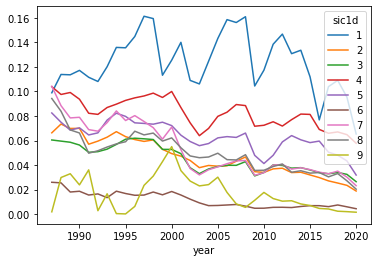

In [22]:
ind_means_unstacked['w_inv'].dropna().plot();

Sector 1 is "Mining and Construction" and Sector 6 is "Financials" so it makes sense that they have drastically different levels of physical investment. To plot just those two sectors, we have to use ``.loc[]`` to extract them from the overall dataframe before we use ``.plot()``: 

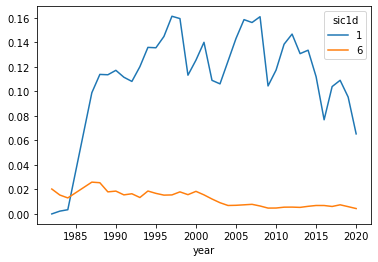

In [23]:
ind_means_unstacked['w_inv'].loc[:, ['1','6']].dropna().plot();

To test yourself, see if you can tell why the line below produces the same result:

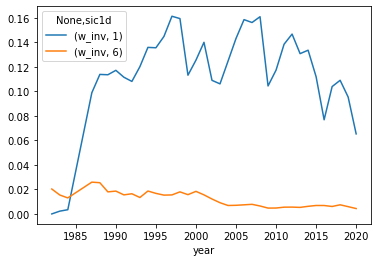

In [24]:
ind_means_unstacked.loc[:, [('w_inv','1'), ('w_inv','6')]].dropna().plot();

**Challange**:

Create a similar plot to the one above, but this time for profitability (roa). Also, this time, place each sector (1 and 6) in a separate subplot. 

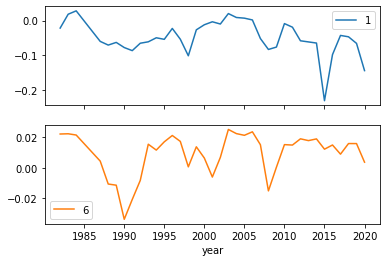

In [25]:
ind_means_unstacked['w_roa'].loc[:, ['1','6']].dropna().plot(subplots=True);

# Advanced "binning" example 

In many cases, our analysis requires us to split our sample in bins (groups) based on how firms rank in terms of one specific variable. Then some analysis is performed separately for each bin. 

To showcase this type of subsample analysis, in the examples below, we analyze if the evolution of cash holdings over time looks different for firms with different levels of profitability.

To do this, we need to define what we mean by "different levels of profitability". One approach could be to use specific values of profitability: e.g. put all firms with ROA larger than 20\% in a "high profitability" bin, etc. However, these levels would be a bit arbitrary (why 20\% and not 25\%). 

Instead, a more common approach is to simply split firms into a number of equaly sized bins (same number of firms in each bin). For example, below, we split firms into 5 equaly-sized "bins" based on how their profitability ranks among the rest of profitability data (5 equaly-size groups are often called "quintiles", 4 = "quartiles", 3 = "terciles, 10 = "deciles")

First, let's look again at how average cash-holdings evolve over time, when we use the full cross-section:

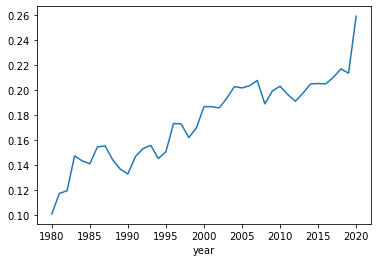

In [26]:
comp.groupby('year')['w_cash'].mean().plot();

Now we can use the ``.qcut()`` function to create the 5 profitability bins.

Syntax:
```python
pandas.qcut(x, q, labels=None, retbins=False, precision=3, duplicates='raise')
```

In [27]:
comp['roa_quintile'] = pd.qcut(comp['roa'], q = 5, labels = range(1,6))
comp[['roa','roa_quintile']]

,roa,roa_quintile
188730,-0.345154,1
188550,0.054648,4
188566,0.026506,3
188567,0.046187,4
188568,0.065069,4
...,...,...
493016,-0.029779,2
493017,-0.068448,2
493020,-0.032821,2
493021,-0.025125,2


And check that these are "equally-sized bins":

In [28]:
comp['roa_quintile'].value_counts()

1    47295
5    47295
2    47294
3    47294
4    47294
Name: roa_quintile, dtype: int64

Now take a look at the trends in cash holdings, separately, for firm in different ROA bins:

In [29]:
qmeans = comp.groupby(['year','roa_quintile'])['w_cash'].mean()
qmeans

year  roa_quintile
1980  1               0.141184
      2               0.123049
      3               0.076496
      4               0.073829
      5               0.123347
                        ...   
2020  1               0.476157
      2               0.158032
      3               0.115881
      4               0.156380
      5               0.248309
Name: w_cash, Length: 205, dtype: float64

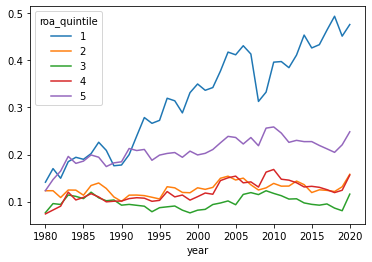

In [30]:
qmeans.unstack('roa_quintile').plot();

It looks like the strong positive trend in cash holdings is only there for firms with the lowest profitability.

## Multi-dimensional bins

In the example below, we redo this analysis, but this time, to judge which firm goes into which ROA bin, we compare profitability levels only amongst firms in a given year (and we do this for all years).

To do this, we need to use the ``.transform()`` function we introduced in the last lecture. We supply ``pd.qcut`` as a parameter to ``.transform()``.  

In [31]:
comp['roa_q'] = comp.groupby('year')['roa'].transform(lambda x: pd.qcut(x, q=5, labels = range(1,6)))

Note that the ``lambda x`` tells Python that, what follows after it (i.e. pd.qcut) should be seen as a function of x. So the line of code above splits the "roa" data in years, then, it takes the roa data each year, calls it "x" and then supplies it as an input to the ``pd.qcut()`` function. That function uses that roa information to split firms into quintiles (q=5) based on how their roa ranks amongst all other firms that year. These quintiles are given names 1 through 5 (labels = range(1,6)), and stored in a new column called "roa_q" inside the "comp" dataframe.  

Let's take a look at these quintile, as well as the ones we created in the prior section, and the roa levels themselves: 

In [32]:
comp[['roa','roa_quintile','roa_q']]

,roa,roa_quintile,roa_q
188730,-0.345154,1,1
188550,0.054648,4,4
188566,0.026506,3,3
188567,0.046187,4,4
188568,0.065069,4,4
...,...,...,...
493016,-0.029779,2,2
493017,-0.068448,2,2
493020,-0.032821,2,2
493021,-0.025125,2,2


In [33]:
comp['roa_q'].value_counts()

1    47310
5    47301
2    47289
4    47289
3    47283
Name: roa_q, dtype: int64

Now we recalculate cash holding trends separately for each ROA bin, using these new bins:

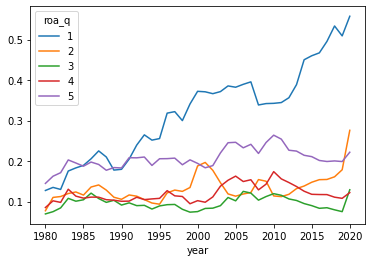

In [35]:
comp.groupby(['year','roa_q'])['w_cash'].mean().unstack('roa_q').plot();

This looks very similar to what we found in the prior section: the result that "firms seem to be holding a lot more cash now" holds only for firms with the lowest profitability. What do you think could account for these findings? 